# Entrainement finetune de modèles pré-entraînés
Ce notebook présente :
- Pipeline de prétraitement à partir des splits de finetune
- Définition d’un modèle pré-entraîné
- Entraînement et évaluation
- Sauvegarde du meilleur modèle

## Imports & Setup

In [2]:
import os
import warnings
import pandas as pd
from datetime import date
import shutil
import subprocess
import tensorflow as tf
from sklearn.utils import resample
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics as km
from src.config_utils import load_config
from src.preprocessing_finetune import get_train_datagen, get_val_datagen
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from src.metrics import (
    compute_confusion_matrix, plot_confusion_matrix,
    compute_roc_pr, plot_roc_pr,
    compute_additional_metrics, calibration_plot,
    threshold_metrics_curve
)

In [3]:
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="keras\\.src\\.trainers\\.data_adapters\\.py_dataset_adapter"
)

CFG_OUT  = os.path.join('..','outputs','configs','all')
FIG_OUT  = os.path.join('..','outputs','figures', 'all', 'finetune')
LOG_OUT  = os.path.join('..','outputs','logs', 'all', 'finetune')

for d in (CFG_OUT, FIG_OUT, LOG_OUT):
    os.makedirs(d, exist_ok=True)

# Génération du Run ID: date + git hash
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

# Chargement de la configuration via un chemin relatif
config = load_config('../configs/config_finetune.yaml')
tf.random.set_seed(config['seed'])

print("Run ID :", run_id)

Run ID : 2025-07-06_b981341


##  Lecture des splits et création des DataFrames

In [3]:
train_txt = "../splits/all/finetune/train.txt"
val_txt   = "../splits/all/finetune/val.txt"

with open(train_txt) as f: train_files = [l.strip() for l in f]
with open(val_txt)   as f: val_files   = [l.strip() for l in f]

train_df = pd.DataFrame({
    'filename': train_files,
    'class': [os.path.basename(os.path.dirname(p)) for p in train_files]
})

df_major = train_df[train_df['class']=='toxic']
df_minor = train_df[train_df['class']=='non-toxic']
df_minor_upsampled = resample(
    df_minor,
    replace=True,
    n_samples=len(df_major),
    random_state=config['seed']
)

train_df = pd.concat([df_major, df_minor_upsampled]).sample(frac=1, random_state=config['seed'])

val_df = pd.DataFrame({
    'filename': val_files,
    'class': [os.path.basename(os.path.dirname(p)) for p in val_files]
})

## Générateurs Keras

In [4]:
train_datagen = get_train_datagen(config)
val_datagen   = get_val_datagen()

cw = config['loss']['class_weights']

train_df['weights'] = train_df['class'].map(cw)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    weight_col='weights',
    target_size=tuple(config['input']['size']),
    batch_size=config['input']['batch_size'],
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=tuple(config['input']['size']),
    batch_size=config['input']['batch_size'],
    class_mode='binary',
    shuffle=False
)

Found 413 validated image filenames belonging to 2 classes.
Found 89 validated image filenames belonging to 2 classes.


## Construction du modèle

In [5]:
base = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet' if config['model']['pretrained'] else None,
    input_shape=tuple(config['input']['size']) + (3,),
    pooling='avg'
)

for layer in base.layers[:100]:
    layer.trainable = False

x = layers.Dropout(0.6)(base.output)
output = layers.Dense(config['model']['num_classes'])(x)
model = models.Model(inputs=base.input, outputs=output)

## Compilation

In [6]:
opt = optimizers.AdamW(
    learning_rate=float(config['training']['optimizer']['lr']),
    weight_decay=float(config['training']['optimizer']['weight_decay'])
)

# loss_fn = losses.BinaryCrossentropy(from_logits=True)

loss_fn = losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True)

metric_list = [
    'accuracy',
    km.Precision(name='precision_toxic'),
    km.Recall(name='recall_toxic'),
    km.AUC(name='roc_auc'),
    km.AUC(name='pr_auc', curve='PR')
]

model.compile(optimizer=opt, loss=loss_fn, metrics=metric_list)

# model.summary()

## Callbacks et chemins

In [7]:
ckpt_dir = "../outputs/checkpoints/all/finetune"
os.makedirs(ckpt_dir, exist_ok=True)

ckpt_path = os.path.join(ckpt_dir, 'finetune_resnet50.keras')

es = callbacks.EarlyStopping(
    monitor=config['training']['callbacks']['early_stopping']['monitor'],
    mode=config['training']['callbacks']['early_stopping']['mode'],
    patience=config['training']['callbacks']['early_stopping']['patience']
)

mc = callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    monitor=config['training']['callbacks']['model_checkpoint']['monitor'],
    mode=config['training']['callbacks']['model_checkpoint']['mode'],
    save_best_only=True
)

## Entraînement

In [8]:
history = model.fit(
    train_gen,
    epochs=config['training']['epochs'],
    validation_data=val_gen,
    callbacks=[es, mc],
)

Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.6619 - loss: 0.2852 - pr_auc: 0.8057 - precision_toxic: 0.8198 - recall_toxic: 0.5627 - roc_auc: 0.7387 - val_accuracy: 0.4157 - val_loss: 0.7991 - val_pr_auc: 0.5843 - val_precision_toxic: 0.0000e+00 - val_recall_toxic: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8491 - loss: 0.1534 - pr_auc: 0.9184 - precision_toxic: 0.9553 - recall_toxic: 0.7746 - roc_auc: 0.8765 - val_accuracy: 0.4157 - val_loss: 1.0008 - val_pr_auc: 0.5843 - val_precision_toxic: 0.0000e+00 - val_recall_toxic: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9100 - loss: 0.1131 - pr_auc: 0.9339 - precision_toxic: 0.9425 - recall_toxic: 0.9052 - roc_auc: 0.9304 - val_accuracy: 0.5843 - val_loss: 3.1806 - val_pr_auc: 0.5843 - val_precision_toxic: 0.5843 - val_recall_toxic: 1.0000 - val_roc_auc: 0.5000
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - ac

## Sauvegarde de l’historique

In [9]:
hist_path = '../outputs/checkpoints/all/finetune/history_finetune_resnet50.pkl'
pd.to_pickle(history.history, hist_path)

# Sauvegarde de la config du run
src_cfg = '../configs/config_finetune.yaml'
dst_cfg = os.path.join(CFG_OUT, f"{run_id}_config_finetune.yaml")
shutil.copy(src_cfg, dst_cfg)
print("Config sauvegardée dans :", dst_cfg)

Config sauvegardée dans : ../outputs/configs/all/2025-07-06_4e06306_config_finetune.yaml


## Tracé des courbes d’entraînement

Courbes sauvegardées dans : ../outputs/figures/all/finetune/2025-07-06_4e06306_training_curves.png


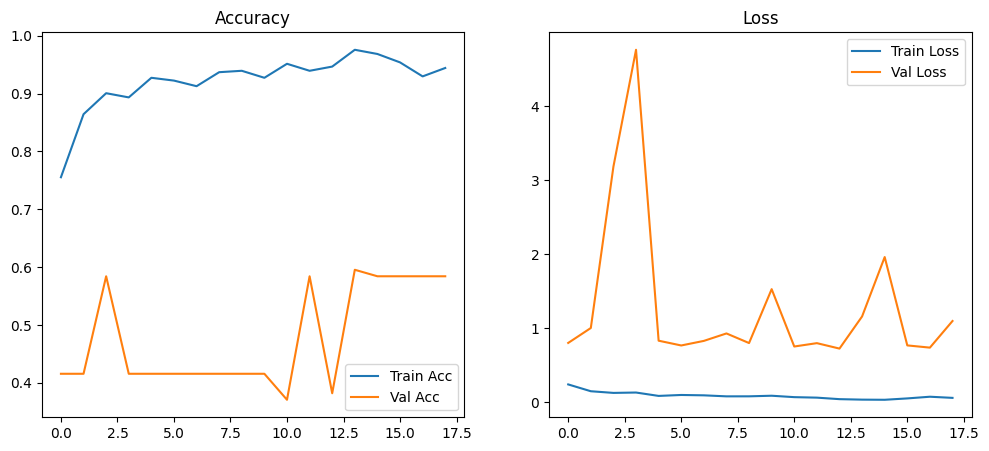

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")

# Sauvegarde de la figure des courbes
fig_path = os.path.join(FIG_OUT, f"{run_id}_training_curves.png")
plt.savefig(fig_path, dpi=300)
print("Courbes sauvegardées dans :", fig_path)

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step
Matrice sauvegardée dans : ../outputs/figures/all/finetune/2025-07-06_4e06306_confusion_matrix.png


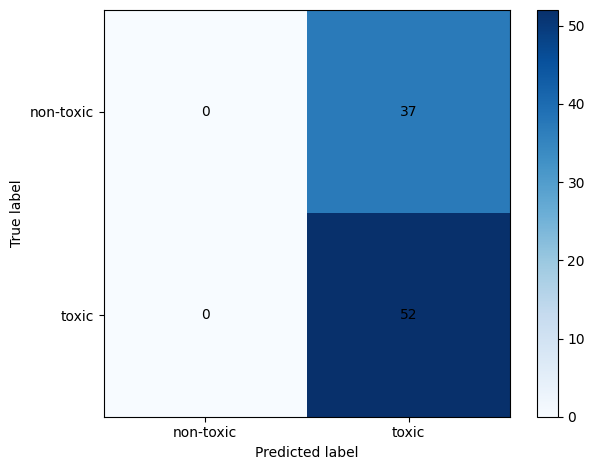

In [15]:
# 1) Prévisions sur le set de val
logits = model.predict(val_gen)
y_score = tf.sigmoid(logits).numpy().ravel()
y_true  = val_gen.classes

thresh_df = threshold_metrics_curve(y_true, y_score, name='ResNet50', n_thresholds=100, return_df=True)

# Choix du seuil maximisant la F1
best_row = thresh_df.loc[thresh_df['f1'].idxmax()]
opt_threshold = best_row['threshold']
print(f"Seuil optimal (F1 max = {best_row['f1']:.3f}) : {opt_threshold:.2f}")

y_pred = (y_score >= opt_threshold).astype(int)

# 2) Matrice de confusion
cm = compute_confusion_matrix(y_true, y_pred, normalize=False)

plot_confusion_matrix(cm)

# Sauvegarde de la matrice
fig_path = os.path.join(FIG_OUT, f"{run_id}_confusion_matrix.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print("Matrice sauvegardée dans :", fig_path)

plt.show()

Report CSV sauvegardé dans : ../outputs/figures/all/finetune/2025-07-06_4e06306_classification_report.csv
Report image sauvegardé dans : ../outputs/figures/all/finetune/2025-07-06_4e06306_classification_report.png


,precision,recall,f1-score,support
0,0.000000,0.00000,0.000000,37.00000
1,0.584270,1.00000,0.737589,52.00000
accuracy,0.584270,0.58427,0.584270,0.58427
macro avg,0.292135,0.50000,0.368794,89.00000
weighted avg,0.341371,0.58427,0.430951,89.00000


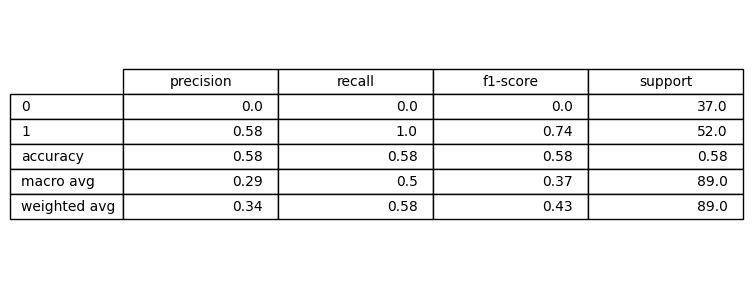

In [16]:
# 3) Classification report
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Sauvegarde du rapport
report_df = pd.DataFrame(report).T
csv_path = os.path.join(FIG_OUT, f"{run_id}_classification_report.csv")
report_df.to_csv(csv_path, index=True)
print("Report CSV sauvegardé dans :", csv_path)

fig, ax = plt.subplots(figsize=(8, len(report_df) * 0.5 + 1))
ax.axis('off')

table = ax.table(
    cellText=report_df.round(2).values,
    rowLabels=report_df.index,
    colLabels=report_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

img_path = os.path.join(FIG_OUT, f"{run_id}_classification_report.png")
fig.savefig(img_path, dpi=300, bbox_inches='tight')
print("Report image sauvegardé dans :", img_path)

display(report_df)

ROC & PR sauvegardées dans : ../outputs/figures/all/finetune/2025-07-06_4e06306_ROC_PR.png


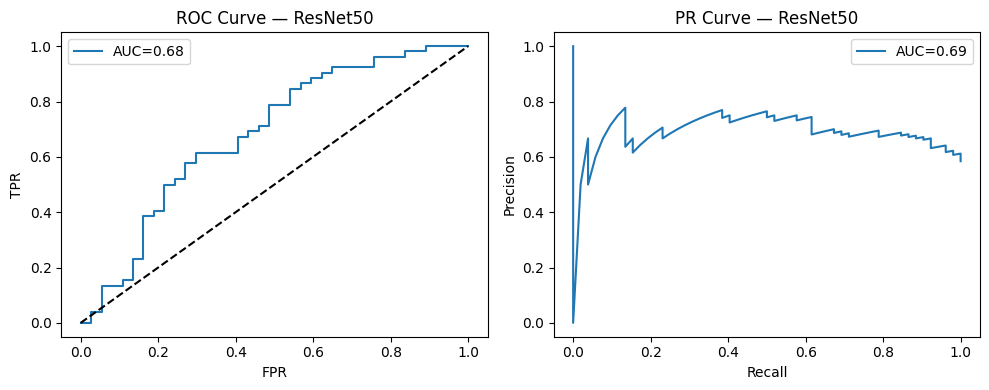

In [18]:
# 4) ROC & PR
roc_pr, pr = compute_roc_pr(y_true, y_score)

plot_roc_pr(roc_pr, pr, name='ResNet50')

# Sauvegarde des ROC & PR
fig_path = os.path.join(FIG_OUT, f"{run_id}_ROC_PR.png")
plt.savefig(fig_path, dpi=300)
print("ROC & PR sauvegardées dans :", fig_path)

plt.show()

Courbe de calibration sauvegardées dans : ../outputs/figures/all/finetune/2025-07-06_4e06306_calibration.png


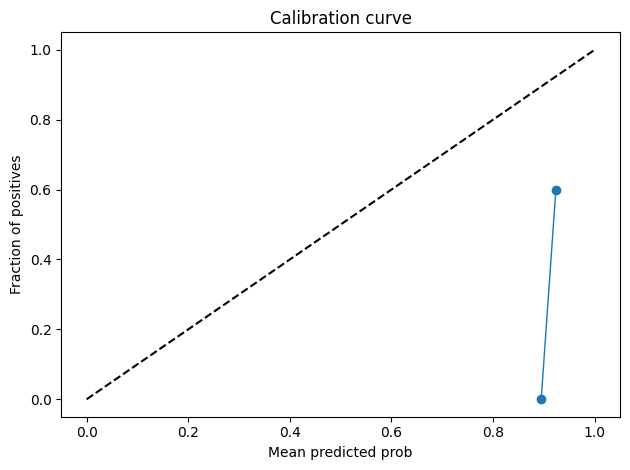

In [19]:
# 5) Calibration
calibration_plot(y_true, y_score, n_bins=10)

# Sauvegarde de la courbe de calibration
fig_path = os.path.join(FIG_OUT, f"{run_id}_calibration.png")
plt.savefig(fig_path, dpi=300)
print("Courbe de calibration sauvegardées dans :", fig_path)

plt.show()

In [20]:
# 6) MCC, balanced acc
met = compute_additional_metrics(y_true, y_pred, y_score)
print(f"MCC: {met['mcc']:.3f}  —  Balanced acc: {met['balanced_acc']:.3f}")

MCC: 0.000  —  Balanced acc: 0.500


Threshold metrics sauvegardées dans : ../outputs/figures/all/finetune/2025-07-06_4e06306_threshold_mertics.png


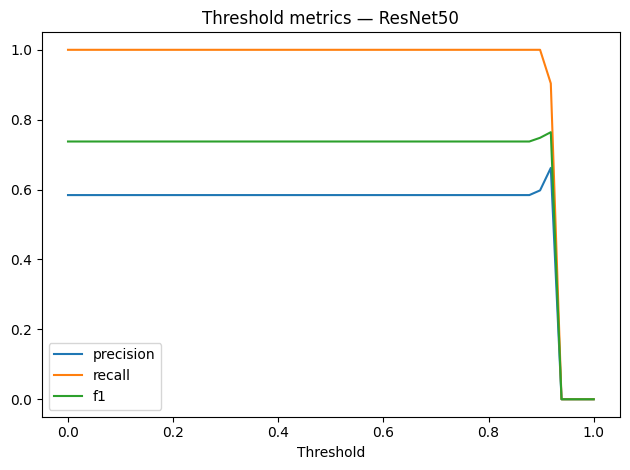

In [21]:
# 7) Courbes selon seuil
threshold_metrics_curve(y_true, y_score, name='ResNet50')

# Sauvegarde des Threshold
fig_path = os.path.join(FIG_OUT, f"{run_id}_threshold_mertics.png")
plt.savefig(fig_path, dpi=300)
print("Threshold metrics sauvegardées dans :", fig_path)

plt.show()